In [1]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer.primitives import EstimatorV2, SamplerV2

from circuit_knitting.cutting import (
    partition_problem,
    generate_cutting_experiments,
    reconstruct_expectation_values,
)

from circuit_knitting.cutting.instructions import CutWire
from circuit_knitting.cutting import cut_wires, expand_observables

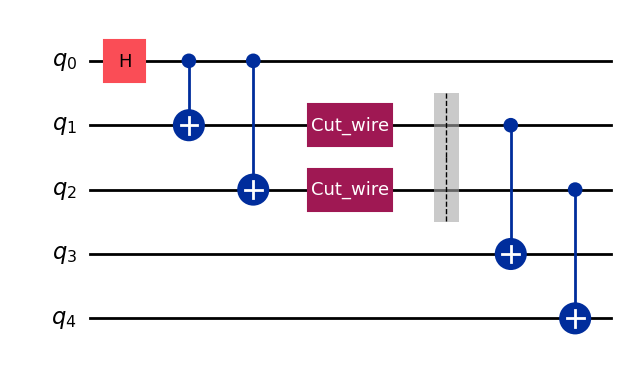

In [48]:
qc = QuantumCircuit(5)
qc.h(0)
qc.cx(0,1)

qc.cx(0,2)

qc.append(CutWire(), [1])

qc.append(CutWire(), [2])
qc.barrier(range(1,3))
qc.cx(1,3)

qc.cx(2,4)
qc.draw("mpl")

In [49]:
observable = SparsePauliOp(["ZIIII"])

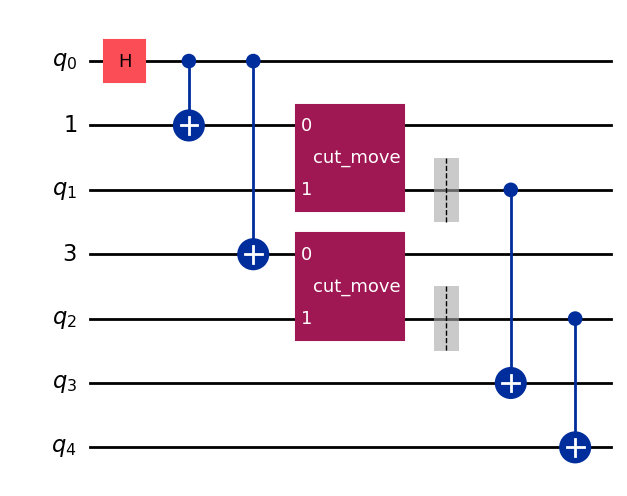

In [50]:
qc_1 = cut_wires(qc)
qc_1.draw("mpl")

In [51]:
observable_expanded_paulis = expand_observables(observable.paulis, qc, qc_1)
observable_expanded_paulis

PauliList(['ZIIIIII'])

In [52]:
partitioned_problem = partition_problem(
    circuit=qc_1, observables=observable_expanded_paulis
)
subcircuits = partitioned_problem.subcircuits
subobservables = partitioned_problem.subobservables

In [53]:
subobservables

{0: PauliList(['III']), 1: PauliList(['ZIII'])}

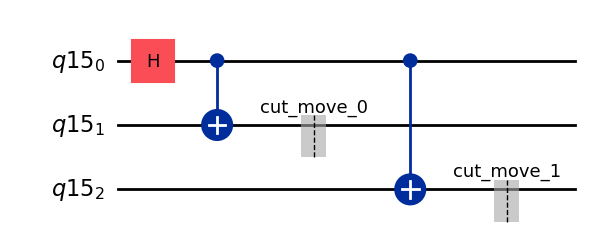

In [54]:
subcircuits[0].draw("mpl")

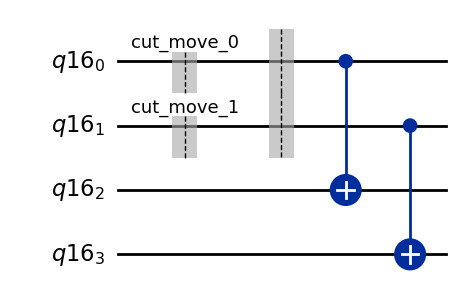

In [55]:
subcircuits[1].draw("mpl")

In [58]:
from qiskit.transpiler.passes import RemoveBarriers
rb=RemoveBarriers()
subcircuits[1]=rb(subcircuits[1])
subcircuits[0]=rb(subcircuits[0])

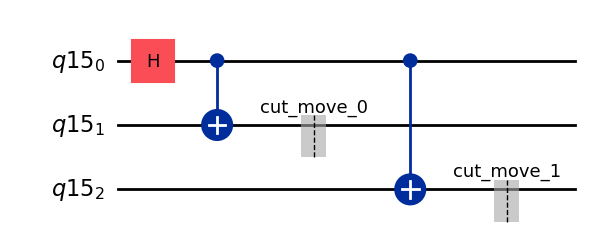

In [59]:
subcircuits[0].draw("mpl")

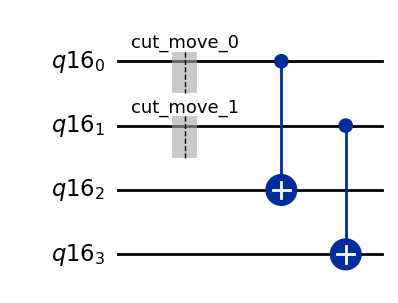

In [60]:
subcircuits[1].draw("mpl")

In [61]:
subexperiments, coefficients = generate_cutting_experiments(
    circuits=subcircuits,
    observables=subobservables,
    num_samples=np.inf,
)

In [62]:
sampler = SamplerV2()
results = {
    label: sampler.run(subexperiment, shots=2**12).result()
    for label, subexperiment in subexperiments.items()
}

In [63]:
reconstructed_expvals = reconstruct_expectation_values(
    results,
    coefficients,
    subobservables,
)
final_expval = np.dot(reconstructed_expvals, observable.coeffs)

In [64]:
estimator = EstimatorV2()
exact_expval = (
    estimator.run([(qc.decompose("cut_wire"), observable)]).result()[0].data.evs
)
print(f"Reconstructed expectation value: {np.real(np.round(final_expval, 8))}")
print(f"Exact expectation value: {np.round(exact_expval, 8)}")
print(f"Error in estimation: {np.real(np.round(final_expval-exact_expval, 8))}")
print(
    f"Relative error in estimation: {np.real(np.round((final_expval-exact_expval) / exact_expval, 8))}"
)

Reconstructed expectation value: -0.00464505
Exact expectation value: 0.0
Error in estimation: -0.00464505
Relative error in estimation: -inf


C:\Users\shikh\AppData\Local\Temp\ipykernel_13296\1330935100.py:9: RuntimeWarning: divide by zero encountered in divide
  f"Relative error in estimation: {np.real(np.round((final_expval-exact_expval) / exact_expval, 8))}"
C:\Users\shikh\AppData\Local\Temp\ipykernel_13296\1330935100.py:9: RuntimeWarning: invalid value encountered in divide
  f"Relative error in estimation: {np.real(np.round((final_expval-exact_expval) / exact_expval, 8))}"
